In [1]:
!pip install ucimlrepo

In [2]:
import warnings
warnings.filterwarnings('ignore')


import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
raisin = fetch_ucirepo(id=850)

# data (as pandas dataframes)
X = raisin.data.features
y = raisin.data.targets
df = pd.DataFrame(X, columns=raisin.data.feature_names)
df['Class'] = y

print("1) Data Pre-processing\n")
print("First 5 rows of df:")
display(df.head())

print("\nMissing values per column:")
print(df.isnull().sum())
if df.isnull().any().any():
    print("\nHandling missing values: applying simple imputation (median).")
    df = df.fillna(df.median(numeric_only=True))

1) Data Pre-processing

First 5 rows of df:


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen



Missing values per column:
Area               0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
Extent             0
Perimeter          0
Class              0
dtype: int64


In [4]:
print("Unique values in 'Class' column before mapping:")
print(df['Class'].unique())
df['Class'] = df['Class'].map({'Kecimen': 0, 'Besni': 1})
df.dropna(subset=['Class'], inplace=True)
X = df.drop(columns=['Class'])
y = df['Class']
mi = mutual_info_classif(X, y, random_state=42)
mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("\nMutual Information Scores:")
print(mi_scores)
drop_feature = mi_scores.idxmin()
print(f"\nDropping least important feature: {drop_feature}")
X = X.drop(columns=[drop_feature])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Unique values in 'Class' column before mapping:
['Kecimen' 'Besni']

Mutual Information Scores:
Perimeter          0.358507
MajorAxisLength    0.348341
ConvexArea         0.297530
Area               0.277582
MinorAxisLength    0.134869
Eccentricity       0.129117
Extent             0.029344
dtype: float64

Dropping least important feature: Extent
Train shape: (720, 6), Test shape: (180, 6)


In [5]:
def evaluate_model(name, model, X_test, y_test, verbose=True):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    if verbose:
        print(f"\n{name}")
        print("Confusion Matrix:\n", cm)
        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall: {rec:.4f}")
        print(f"F1 Score: {f1:.4f}")

    return {"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}


In [6]:
# Cell 6: Bagging Classifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    random_state=42
)
bag.fit(X_train_scaled, y_train)

results = []
results.append(evaluate_model("Bagging (default)", bag, X_test_scaled, y_test))

# Hyperparameter tuning
param_grid_bag = {
    "n_estimators": [50, 100, 200],
    "max_samples": [0.5, 0.7, 1.0],
    "max_features": [0.5, 1.0],
    "estimator__max_depth": [None, 3, 5]
}

bag_gs = GridSearchCV(bag, param_grid_bag, cv=5, scoring="f1", n_jobs=-1)
bag_gs.fit(X_train_scaled, y_train)
bag_best = bag_gs.best_estimator_

print("\nBest params for Bagging:", bag_gs.best_params_)
results.append(evaluate_model("Bagging (tuned)", bag_best, X_test_scaled, y_test))


Bagging (default)
Confusion Matrix:
 [[80 10]
 [18 72]]
Accuracy: 0.8444
Precision: 0.8780
Recall: 0.8000
F1 Score: 0.8372

Best params for Bagging: {'estimator__max_depth': 5, 'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 50}

Bagging (tuned)
Confusion Matrix:
 [[85  5]
 [15 75]]
Accuracy: 0.8889
Precision: 0.9375
Recall: 0.8333
F1 Score: 0.8824


In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
results.append(evaluate_model("RandomForest (default)", rf, X_test_scaled, y_test))

param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10],
    "max_features": ["sqrt", "log2", 0.7]
}

rf_gs = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring="f1", n_jobs=-1)
rf_gs.fit(X_train_scaled, y_train)
rf_best = rf_gs.best_estimator_

print("\nBest params for Random Forest:", rf_gs.best_params_)
results.append(evaluate_model("RandomForest (tuned)", rf_best, X_test_scaled, y_test))
feature_importances = pd.Series(rf_best.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 10 feature importances:")
print(feature_importances.head(10))

plt.figure(figsize=(8,6))
feature_importances.head(10).plot(kind="bar")
plt.title("Random Forest - Top 10 Features")
plt.show()



RandomForest (default)
Confusion Matrix:
 [[81  9]
 [15 75]]
Accuracy: 0.8667
Precision: 0.8929
Recall: 0.8333
F1 Score: 0.8621


In [14]:
adab = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    random_state=42
)
adab.fit(X_train_scaled, y_train)
results.append(evaluate_model("AdaBoost (default)", adab, X_test_scaled, y_test))

param_grid_adab = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 1.0],
    "estimator__max_depth": [1, 2]
}

adab_gs = GridSearchCV(
    AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42), random_state=42),
    param_grid_adab, cv=5, scoring="f1", n_jobs=-1
)
adab_gs.fit(X_train_scaled, y_train)
adab_best = adab_gs.best_estimator_

print("\nBest params for AdaBoost:", adab_gs.best_params_)
results.append(evaluate_model("AdaBoost (tuned)", adab_best, X_test_scaled, y_test))


AdaBoost (default)
Confusion Matrix:
 [[82  8]
 [12 78]]
Accuracy: 0.8889
Precision: 0.9070
Recall: 0.8667
F1 Score: 0.8864

Best params for AdaBoost: {'estimator__max_depth': 2, 'learning_rate': 0.1, 'n_estimators': 200}

AdaBoost (tuned)
Confusion Matrix:
 [[85  5]
 [13 77]]
Accuracy: 0.9000
Precision: 0.9390
Recall: 0.8556
F1 Score: 0.8953


In [15]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_scaled, y_train)
results.append(evaluate_model("GradientBoosting (default)", gb, X_test_scaled, y_test))

param_grid_gb = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [2, 3, 5],
    "subsample": [0.8, 1.0]
}

gb_gs = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=5, scoring="f1", n_jobs=-1)
gb_gs.fit(X_train_scaled, y_train)
gb_best = gb_gs.best_estimator_

print("\nBest params for GradientBoosting:", gb_gs.best_params_)
results.append(evaluate_model("GradientBoosting (tuned)", gb_best, X_test_scaled, y_test))



GradientBoosting (default)
Confusion Matrix:
 [[78 12]
 [14 76]]
Accuracy: 0.8556
Precision: 0.8636
Recall: 0.8444
F1 Score: 0.8539

Best params for GradientBoosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

GradientBoosting (tuned)
Confusion Matrix:
 [[80 10]
 [16 74]]
Accuracy: 0.8556
Precision: 0.8810
Recall: 0.8222
F1 Score: 0.8506


In [16]:
lr = LogisticRegression(max_iter=1000, random_state=42)

voting_hard = VotingClassifier(
    estimators=[("lr", lr), ("rf", rf_best), ("gb", gb_best)], voting="hard"
)
voting_soft = VotingClassifier(
    estimators=[("lr", lr), ("rf", rf_best), ("gb", gb_best)], voting="soft"
)

voting_hard.fit(X_train_scaled, y_train)
voting_soft.fit(X_train_scaled, y_train)

results.append(evaluate_model("Voting (hard)", voting_hard, X_test_scaled, y_test))
results.append(evaluate_model("Voting (soft)", voting_soft, X_test_scaled, y_test))



Voting (hard)
Confusion Matrix:
 [[82  8]
 [15 75]]
Accuracy: 0.8722
Precision: 0.9036
Recall: 0.8333
F1 Score: 0.8671

Voting (soft)
Confusion Matrix:
 [[81  9]
 [14 76]]
Accuracy: 0.8722
Precision: 0.8941
Recall: 0.8444
F1 Score: 0.8686


In [17]:
stack = StackingClassifier(
    estimators=[("knn", KNeighborsClassifier()), ("rf", rf_best), ("gb", gb_best)],
    final_estimator=LogisticRegression(max_iter=1000),
    n_jobs=-1
)
stack.fit(X_train_scaled, y_train)
results.append(evaluate_model("Stacking", stack, X_test_scaled, y_test))



Stacking
Confusion Matrix:
 [[80 10]
 [15 75]]
Accuracy: 0.8611
Precision: 0.8824
Recall: 0.8333
F1 Score: 0.8571



Summary of Results:
                            Accuracy  Precision    Recall        F1
Model                                                              
Bagging (default)           0.844444   0.878049  0.800000  0.837209
Bagging (tuned)             0.888889   0.937500  0.833333  0.882353
AdaBoost (default)          0.888889   0.906977  0.866667  0.886364
AdaBoost (tuned)            0.900000   0.939024  0.855556  0.895349
GradientBoosting (default)  0.855556   0.863636  0.844444  0.853933
GradientBoosting (tuned)    0.855556   0.880952  0.822222  0.850575
RandomForest (default)      0.866667   0.892857  0.833333  0.862069
RandomForest (tuned)        0.866667   0.892857  0.833333  0.862069
AdaBoost (default)          0.888889   0.906977  0.866667  0.886364
AdaBoost (tuned)            0.900000   0.939024  0.855556  0.895349
GradientBoosting (default)  0.855556   0.863636  0.844444  0.853933
GradientBoosting (tuned)    0.855556   0.880952  0.822222  0.850575
Voting (hard)              

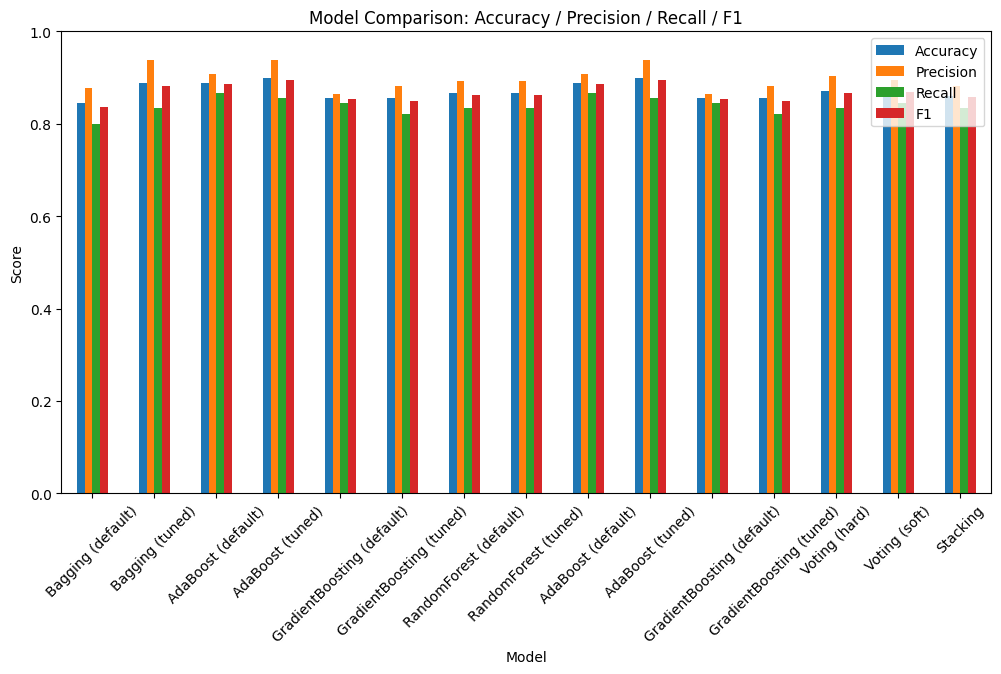

In [18]:
summary_df = pd.DataFrame(results).drop(columns="ConfusionMatrix", errors="ignore")
summary_df = summary_df.set_index("Model")
print("\nSummary of Results:")
print(summary_df)
summary_df.plot(kind="bar", figsize=(12,6))
plt.title("Model Comparison: Accuracy / Precision / Recall / F1")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.show()
